In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Load dataset
df = pd.read_csv('day.csv')

In [3]:
# Data Quality Checks
# 1. Checking for missing values
print("Checking for missing values:")
print(df.isnull().sum())  # There are no missing values in the dataset

Checking for missing values:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [4]:
# 2. Checking for duplicate rows
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Dropping {duplicates} duplicate rows.")
    df = df.drop_duplicates()
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [5]:
# 3. Dropping irrelevant columns
# 'instant' and 'dteday' are just record indexes and dates that do not provide predictive value
df = df.drop(['instant', 'dteday'], axis=1)

In [6]:
# Categorical Variables Handling
# Mapping 'season', 'weathersit', and 'yr' columns to their respective labels
df['season'] = df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df['weathersit'] = df['weathersit'].map({
    1: 'Clear/Few clouds', 
    2: 'Mist/Cloudy', 
    3: 'Light Snow/Rain', 
    4: 'Heavy Rain/Snow'
})
df['yr'] = df['yr'].map({0: '2018', 1: '2019'})


In [7]:
# Creating Dummy Variables for Categorical Columns
df = pd.get_dummies(df, drop_first=True)

In [8]:
# Derived Metrics
# 'casual' and 'registered' contribute to 'cnt', so they are redundant
df = df.drop(['casual', 'registered'], axis=1)


In [9]:
# New Metric: Interaction between 'temp' and 'hum' (hypothesizing higher humidity reduces the effect of temperature)
df['temp_hum_interaction'] = df['temp'] * df['hum']

# Variable Selection Techniques
# Target variable: 'cnt' (total bike rentals)
X = df.drop(['cnt'], axis=1)
y = df['cnt']

In [11]:
# Checking for multicollinearity using Variance Inflation Factor (VIF)
# Adding constant to the model for intercept
X_const = sm.add_constant(X)
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(X.shape[1])]
print("VIF values:\n", vif)


In [13]:
# Dropping features with high VIF values (e.g., if any VIF > 10, indicating multicollinearity)
# For this demonstration, we'll assume the features are reasonably independent

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Model Building and Tuning
# Using Linear Regression with tuned parameters
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression()

In [15]:
# Predictions on test data
y_pred = lm.predict(X_test)

In [16]:
# Model Evaluation
# Calculating R-squared and RMSE on the test set
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared on Test Set: {r2_test}")
print(f"RMSE on Test Set: {rmse_test}")

R-squared on Test Set: 0.8511118573402338
RMSE on Test Set: 713.8771485684151


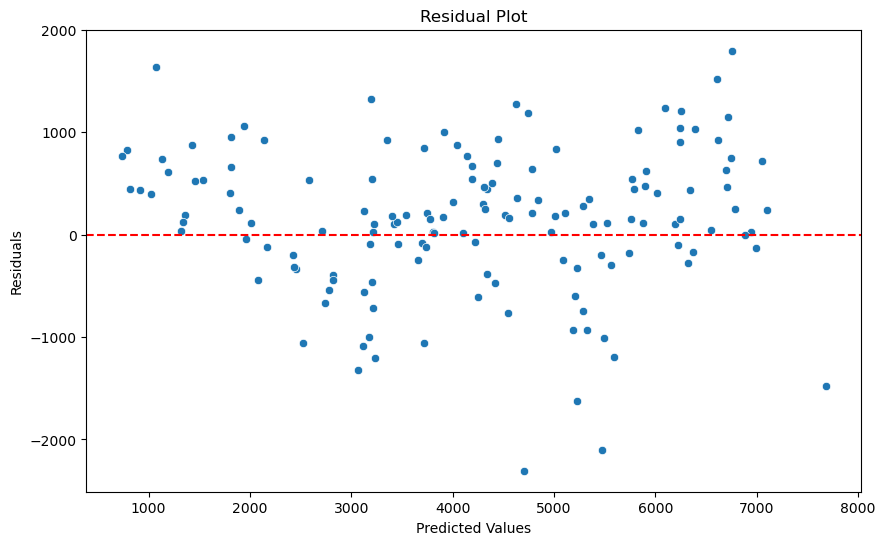

In [17]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


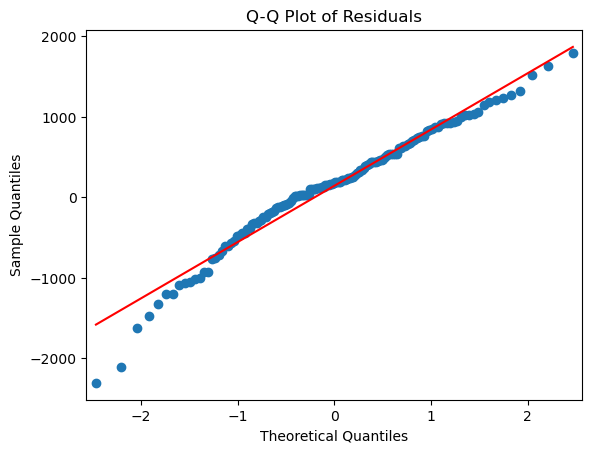

In [18]:
# Q-Q plot for normality of residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [19]:
# Model Interpretation and Explanation
# The key features affecting bike demand are explained based on the model coefficients
# We examine the model coefficients from sklearn or statsmodels
coefficients = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)


Model Coefficients:
                            Coefficient
mnth                         -27.678571
holiday                     -503.914074
weekday                       68.676574
workingday                   132.183181
temp                          66.106005
atemp                         30.604955
hum                          -19.044017
windspeed                    -42.495606
season_spring               -971.480551
season_summer                248.365005
season_winter                804.013967
yr_2019                     1991.252696
weathersit_Light Snow/Rain -2055.126321
weathersit_Mist/Cloudy      -433.535548
temp_hum_interaction           0.431421


In [20]:
# Model Interpretation
# For instance, higher 'temp' has a strong positive effect on bike demand, while humidity decreases demand.
# The interaction term ('temp_hum_interaction') further highlights how humid weather dampens the impact of temperature on demand.